In [2]:
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors

data = sc.textFile("C:/Users/Suhas/Documents/MSBA/Semester Two/Harvesting Big Data/Project/Data/all_data.txt")

Tokenizer

In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

Removing punctuations and numbers

In [4]:
import re
def removePunctuation(text):
    inter1 = re.sub('[^a-z| |]', '', text.strip().lower().encode('utf-8'))
    inter2 = inter1.replace("\'", "")
    return inter2

In [5]:
data_sanspunct = data.map(removePunctuation)

Removing Stop Words

In [6]:
from stop_words import get_stop_words
en_stop = get_stop_words('en')

def removeStopWords(line):
    tokens = tokenizer.tokenize(line)
    words = [i for i in tokens if not i in en_stop]
    return words

In [7]:
data_sansstopwords = data_sanspunct.map(removeStopWords)

Stemming

In [8]:
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def stemmingWords(words):
    stemmed_word = [p_stemmer.stem(i) for i in words]
    return stemmed_word

In [9]:
data_sansstemmingwords = data_sansstopwords.map(stemmingWords)

Creating document-term matrix

In [10]:
import gensim 
from gensim import corpora, models

def documentTermMatrix(texts):
    dictionary = corpora.Dictionary(texts)
    return dictionary

C:\Users\Suhas\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Suhas\Anaconda2\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [11]:
corpus = data_sansstemmingwords.map(lambda word:documentTermMatrix(word))

In [12]:
word_list = data_sansstemmingwords.collect()[0]

In [13]:
doc_clean = [doc.split() for doc in word_list]
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

In [14]:
import gensim
from gensim import corpora, models

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, iterations=3, random_state=7)

In [15]:
# select top 50 words for each of the 20 LDA topics
top_words = [[str(word[0].encode('utf-8')) for word in ldamodel.show_topic(topicno, topn=50)] for topicno in range(ldamodel.num_topics)]

In [16]:
import itertools
import  numpy as np
# get all top 50 words in all 20 topics, as one large set
all_words = set(itertools.chain.from_iterable(top_words))

# for each topic, replace a word at a different index, to make it more interesting
#replace_index = np.random.randint(0, 10, ldamodel.num_topics)

replacements = []
for topicno, words in enumerate(top_words):
#    other_words = all_words.difference(words)
#    replacement = np.random.choice(list(other_words))
#    replacements.append((words[replace_index[topicno]], replacement))
#    words[replace_index[topicno]] = replacement
    print("Topic %i: %s" % (topicno, ' '.join(words[:10])))

Topic 0: time know happen wasnut uthi stand let ever put noth
Topic 1: just come two race still better ufollow ulanda includ expert
Topic 2: player guy complet give comment field went victori michigan uniform
Topic 3: right use chang doesnut late overal america anyth car usual
Topic 4: get countri presid report second bring th highli either line
Topic 5: u leagu slalom pick real thereu stop packer obvious bryant
Topic 6: said game uth fan shot era life news uthatu winud
Topic 7: ui start next made keep mani candid left bradi note
Topic 8: year landau return believ offici four away uwhat washington although
Topic 9: need take lot ball deal papadaki uhe live spent less
Topic 10: like got came new injuri show issu defens roster uin
Topic 11: one donut goal call coach young help eight wear wild
Topic 12: man norman pat train turn cut sure goodel respect thought
Topic 13: way well won miss twitter fact test place dak russia
Topic 14: none never szew told home prix coupl due terribl uuch
Top

In [32]:
import pandas as pd
website_list = ["animalplanet","natgeo","Discovery","TMZ","HISTORY","NBCSports","ESPN","nytimes","cnn","bbc","theatlantic"]
final = pd.DataFrame({"Topics":np.arange(30)})
for website in website_list:
    text = sc.textFile("C:/Users/Suhas/Documents/MSBA/Semester Two/Harvesting Big Data/Project/Data/Website Scraped/"+website+"_top10_posts_BOW_*")
    text = text.map(removePunctuation)
    text = text.map(removeStopWords)
    text = text.map(stemmingWords)

    word_list_1 = text.collect()[0]

    #doc_clean = [doc.split() for doc in word_list]
    #dictionary = corpora.Dictionary(doc_clean)
    #corpus = [dictionary.doc2bow(text) for text in doc_clean]

    doc_clean_1 = [doc.split() for doc in word_list_1]
    #dictionary_1 = corpora.Dictionary(doc_clean_1)
    corpus_1 = [dictionary.doc2bow(text) for text in doc_clean_1]


    #doc_clean_1 = [doc.split() for doc in word_list_1]
    vec_bow = dictionary.doc2bow(word_list_1)
    vec_lsi = ldamodel[vec_bow] # convert the query to LSI space
    vec_lsi

    output = pd.DataFrame(vec_lsi)
    output.columns = ["Topics", website]

    final = final.merge(output)
final.to_csv("topic_probability_clustering.csv",index=False)

In [17]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

In [18]:
# Load and parse the data
data = sc.textFile("C:/Users/Suhas/Documents/MSBA/Semester Two/Harvesting Big Data/Project/Data/clustering_data.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

In [20]:
sse_list = list()
for i in range(1,20):
    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, i, maxIterations=10,
                            runs=10, initializationMode="random", seed = 1234)

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    sse_list.append(WSSSE)
    print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
#clusters.save(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")
#sameModel = KMeansModel.load(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")

Within Set Sum of Squared Error = 0.869162856962
Within Set Sum of Squared Error = 0.628067211737
Within Set Sum of Squared Error = 0.56437505902
Within Set Sum of Squared Error = 0.525472923848
Within Set Sum of Squared Error = 0.485478170919
Within Set Sum of Squared Error = 0.449662611058
Within Set Sum of Squared Error = 0.403843145127
Within Set Sum of Squared Error = 0.370595384415
Within Set Sum of Squared Error = 0.309042521303
Within Set Sum of Squared Error = 0.281523712749
Within Set Sum of Squared Error = 0.290407909418
Within Set Sum of Squared Error = 0.231516480593
Within Set Sum of Squared Error = 0.213888709397
Within Set Sum of Squared Error = 0.213888709397
Within Set Sum of Squared Error = 0.17736532506
Within Set Sum of Squared Error = 0.173749261116
Within Set Sum of Squared Error = 0.161586317645
Within Set Sum of Squared Error = 0.17736532506
Within Set Sum of Squared Error = 0.131260689323


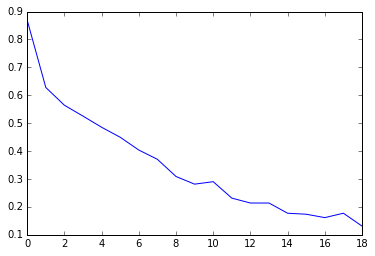

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(sse_list)

In [37]:
import pandas as pd
sse_plot = pd.DataFrame({'k':np.arange(1,20),'sse':sse_list})

In [166]:
clusters.save

<bound method KMeansModel.save of <pyspark.mllib.clustering.KMeansModel object at 0x0000000027894FD0>>

In [168]:
clusters.clusterCenters

[array([ 0.03222045,  0.04118483,  0.02502697,  0.0470347 ,  0.02190892,
         0.02268673,  0.0199363 ,  0.03487252,  0.02681475,  0.02988978,
         0.02413561,  0.03863355,  0.03119778,  0.03880149,  0.04705844,
         0.0357354 ,  0.02817384,  0.02761497]),
 array([ 0.03524044,  0.01072243,  0.02810085,  0.06828123,  0.0217448 ,
         0.02571673,  0.01101781,  0.04704815,  0.05100597,  0.01771262,
         0.01458848,  0.10316807,  0.01858107,  0.0238668 ,  0.03982263,
         0.07477872,  0.12384077,  0.01089842]),
 array([ 0.03222045,  0.04118483,  0.02502697,  0.0470347 ,  0.02190892,
         0.02268673,  0.0199363 ,  0.03487252,  0.02681475,  0.02988978,
         0.02413561,  0.03863355,  0.03119778,  0.03880149,  0.04705844,
         0.0357354 ,  0.02817384,  0.02761497]),
 array([ 0.03607311,  0.03526311,  0.03070915,  0.02538596,  0.0242442 ,
         0.034811  ,  0.03220426,  0.03001514,  0.02681908,  0.0306746 ,
         0.02906785,  0.03109322,  0.03615635,  0.